# Preprocessing data

In [1]:
import json
f= open('train_20230909.jsonl','r',encoding='utf-8')
lines=f.readlines()
f.close()

In [ ]:
dataset=[]
for line in lines:
    json_data=json.loads(line)
    dataset.append(json_data)

In [18]:
from process_data.processor import *

p=processor()
NER_dataframe=p.create_csv(dataset)
NER_dataframe.head()

,Sentence #,Word,POS,Tag
0,0,cái,O,O
1,0,đèn,O,B-dv
2,0,tranh,O,E-dv
3,0,trong,O,O
4,0,nhà,O,B-loc


In [4]:
NER_dataframe.to_csv('NER_Data_processed.csv', index=False)

# NER

## EDA

In [2]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv('NER_Data_processed.csv')

In [4]:
data

,Sentence #,Word,POS,Tag
0,0,cái,O,O
1,0,đèn,O,B-dv
2,0,tranh,O,E-dv
3,0,trong,O,O
4,0,nhà,O,B-loc
...,...,...,...,...
82726,7489,2,O,B-dr
82727,7489,tiếng,O,I-dr
82728,7489,56,O,I-dr
82729,7489,phút,O,E-dr


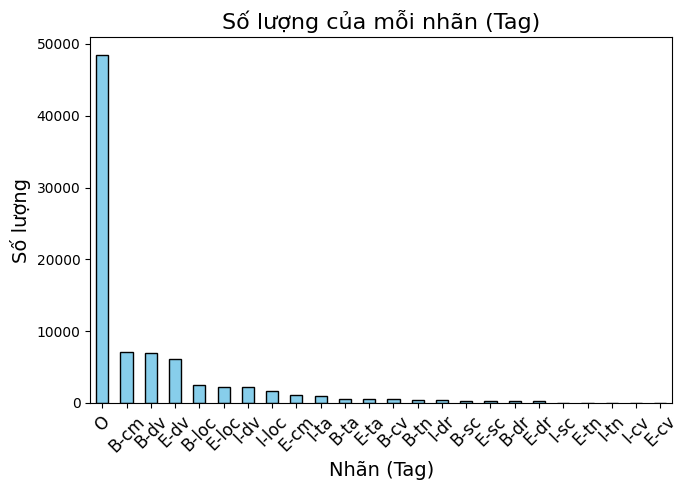

In [7]:
tag_counts = data['Tag'].value_counts()
plt.figure(figsize=(7, 5))
tag_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Số lượng của mỗi nhãn (Tag)', fontsize=16)
plt.xlabel('Nhãn (Tag)', fontsize=14)
plt.ylabel('Số lượng', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.tight_layout()
plt.show()


In [15]:
RE_TAGS = {
  'cv':'changing value',
  'cm':'command',
  'dv':'device',
  'dr':'duration',
  'loc':'location',
  'sc':'scene',
  'tn':'target number',
  'ta':'time at'
}

data['Re_tag'] = data['Tag'].apply(lambda x : RE_TAGS[x.split("-")[1]] if x!='O' else 'O')

In [19]:
data

,Sentence #,Word,POS,Tag,Re_tag
0,0,cái,O,O,O
1,0,đèn,O,B-dv,device
2,0,tranh,O,E-dv,device
3,0,trong,O,O,O
4,0,nhà,O,B-loc,location
...,...,...,...,...,...
82726,7489,2,O,B-dr,duration
82727,7489,tiếng,O,I-dr,duration
82728,7489,56,O,I-dr,duration
82729,7489,phút,O,E-dr,duration


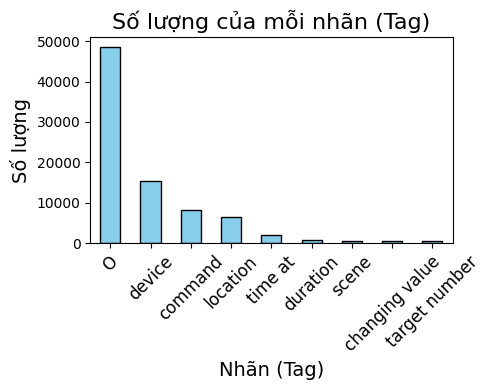

In [26]:
tag_counts = data['Re_tag'].value_counts()
plt.figure(figsize=(5, 4))
tag_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Số lượng của mỗi nhãn (Tag)', fontsize=16)
plt.xlabel('Nhãn (Tag)', fontsize=14)
plt.ylabel('Số lượng', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.tight_layout()
plt.show()


## Prepare data for training

In [5]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent=1
        self.data=data
        self.empty=False
        agg_func=lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(),s["Tag"].values.tolist())]
        self.grouped=self.data.groupby("Sentence #").apply(agg_func)
        self.sentences=[s for s in self.grouped]
    def get_next(self):
        try:
            s=self.grouped["{}".format(self.n_sent)]
            self.n_sent +=1
            return s
        except:
            return None

In [6]:
getter = SentenceGetter(data)
sentences=[[word[0] for word in sentence] for sentence in getter.sentences]
labels=[[tag[1] for tag in sentence] for sentence in getter.sentences]

In [11]:
sequences_sent = []
for sentence in sentences:
    text = ""
    for word in sentence:
        text += f"{word} "
    sequences_sent.append(text.strip())
     

In [6]:
# tag_values=list(set(data['Tag'].values))
# tag_values.append('PAD')
# tag2idx= {t: i for i, t in enumerate(tag_values)}
# idx2tag = {v: k for k, v in tag2idx.items()}

In [8]:
# with open('tag_values.txt','w',encoding='utf-8') as f:
#     for tag in tag_values:
#         f.write(f"{tag}\n")

In [14]:
tag_values=[]
with open('tag_values.txt','r', encoding='utf-8') as f:
    for line in f.readlines():
        tag_values.append(line.strip())
tag2idx= {t: i for i, t in enumerate(tag_values)}
idx2tag = {v: k for k, v in tag2idx.items()}

In [25]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer

from keras.preprocessing.sequence import pad_sequences # type: ignore
from sklearn.model_selection import train_test_split
from data_processor_pipeline.tokenize import *

In [26]:
MAX_LEN = 30
batch_size = 32

In [27]:
tokenizer =BertTokenizer.from_pretrained('viet_bert_tokenizer', do_lower_case = False)
#tokenizer.save_pretrained("./viet_bert_tokenizer")

In [28]:
tokenized_and_preserver_labels = [
    tokenize_and_preserve_labels(sent, labs, tokenizer)
    for sent, labs in zip(sentences, labels)
]

In [29]:
tokenized_texts = [token_labels_pair[0] for token_labels_pair in tokenized_and_preserver_labels]
labels = [token_labels_pair[1] for token_labels_pair in tokenized_and_preserver_labels]

In [30]:
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating='post', padding='post')

In [31]:
tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen = MAX_LEN, value = tag2idx["PAD"], padding="post",
                     dtype="long", truncating = "post")

In [32]:
#attenation mask to ignore PAD token
attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]

In [42]:
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags,
                                                            random_state=2018, test_size=0.1)
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

In [43]:
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

In [44]:
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=16)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=16)

## Implement DL models

### Sequence Model

#### RNN

In [48]:
import torch.nn as nn
from transformers import get_linear_schedule_with_warmup
from transformers import AdamW
from torch.utils.tensorboard import SummaryWriter
from build_model.build_rnn import *
from trainer.trainer import *
import shutil
import os
import pickle

In [49]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_RNN=RNN(30000, embedding_dim=768, output_dim=len(tag2idx)).to(device)
# with open('model_architecture/RNN.pkl', 'wb') as f:
#     pickle.dump(model_RNN, f)
optimizer_RNN = AdamW(
    model_RNN.parameters(),
    lr=0.001,
    eps=1e-8
)
epochs = 3
max_grad_norm = 1.0
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer_RNN,
    num_warmup_steps=0,
    num_training_steps=total_steps
)
criterion=nn.CrossEntropyLoss()
_trainer = trainer()
if os.path.exists('logs/RNN'):
    shutil.rmtree('logs/RNN')
writer = SummaryWriter(log_dir='logs/RNN')

In [50]:
total_params = sum(p.numel() for p in model_RNN.parameters())
trainable_params = sum(p.numel() for p in model_RNN.parameters() if p.requires_grad)

print(f"Tổng số trọng số: {total_params}")
print(f"Số trọng số huấn luyện: {trainable_params}")


Tổng số trọng số: 23107481
Số trọng số huấn luyện: 23107481


In [22]:
best_acc = 0
for epoch in range(epochs):
    _trainer.train(model_RNN, train_dataloader, epoch, epochs, writer, criterion, optimizer_RNN, scheduler, device, len(tag2idx), max_grad_norm)
    val_loss, val_acc = _trainer.validation(model_RNN, valid_dataloader, criterion, device, len(tag2idx))
    print(f"TEST | Epoch: {epoch+1}/{epochs} | Loss: {val_loss:.4f} | Accuracy: {val_acc:.4f}")
    writer.add_scalar('Val/Loss', val_loss, epoch+1)
    writer.add_scalar('Val/Acc', val_acc, epoch+1)
    checkpoint = {
        'model': model_RNN,
        'model_state_dict': model_RNN.state_dict(),
        'epoch': epoch+1,
        'opimizer_state_dict': optimizer_RNN.state_dict(),
    }
    os.makedirs('model_state_dict/RNN', exist_ok=True)
    torch.save(checkpoint, os.path.join('model_state_dict/RNN','last.pth'))
    if val_acc>best_acc:
        torch.save(checkpoint, os.path.join('model_state_dict/RNN','best.pth'))
        best_acc=val_acc

TRAIN | Epoch: 1/3 | Iter: 413/413 | Error: 0/413 | Loss: 0.0201: 100%|███████████████| 413/413 [01:46<00:00,  3.86it/s]


TEST | Epoch: 1/3 | Loss: 0.1153 | Accuracy: 0.9630


TRAIN | Epoch: 2/3 | Iter: 413/413 | Error: 0/413 | Loss: 0.0074: 100%|███████████████| 413/413 [01:48<00:00,  3.82it/s]


TEST | Epoch: 2/3 | Loss: 0.0964 | Accuracy: 0.9652


TRAIN | Epoch: 3/3 | Iter: 413/413 | Error: 0/413 | Loss: 0.0067: 100%|███████████████| 413/413 [01:56<00:00,  3.56it/s]


TEST | Epoch: 3/3 | Loss: 0.0932 | Accuracy: 0.9659


In [23]:
tag_values=[]
with open('tag_values.txt','r', encoding='utf-8') as f:
    for line in f.readlines():
        tag_values.append(line.strip())

In [23]:
import numpy as np
import torch
import pickle
from transformers import BertTokenizer
from inference.inference_ner import *
from build_model.build_rnn import *
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# with open('model_architecture/RNN.pkl', 'rb') as f:
#     model_RNN = pickle.load(f)
#model_RNN=RNN(30000, embedding_dim=768, output_dim=25).to(device)
tokenizer = BertTokenizer.from_pretrained('viet_bert_tokenizer',do_lower_case = False)
state_dict = torch.load('model_state_dict/RNN/best.pth', map_location=device)
model_RNN = state_dict['model']
predict_ner(model_RNN, 'em tăng giúp chị cái đèn chùm ở đầu hè độ sáng đến 89% thôi nhé', tokenizer, tag_values)

tensor([[   2,  269,  173,  384,  248,  502, 1432, 3224,  154,   30,   45, 1144,
          250,  307,   25, 2827,    1, 1170, 1947,    3]])


[{'type': 'command', 'filler': 'tăng'},
 {'type': 'device', 'filler': 'đèn chùm'},
 {'type': 'location', 'filler': 'đầu hè'},
 {'type': 'changing value', 'filler': '89'}]

In [24]:
#model_RNN=RNN(30000, embedding_dim=768, output_dim=len(tag2idx)).to(device)
#model_state_dict=torch.load('model_state_dict/RNN/model_RNN.pth', map_location=device)
#model_RNN = torch.load('model_state_dict/RNN/model_RNN.pth', map_location=device)
_trainer.evaluate_model(model_RNN.to(device), valid_dataloader, idx2tag, device)

{'Accuracy': 0.9659410430839003,
 'Precision': 0.7900704872816426,
 'Recall': 0.8645204560697518,
 'F1-Score': 0.8256204963971175,
 'Exact Match (EM)': 0.4435374149659864}

#### LSTM

In [2]:
import torch
import torch.nn
from transformers import get_linear_schedule_with_warmup
from transformers import AdamW

from torch.utils.tensorboard import SummaryWriter
from build_model.build_lstm import *
from trainer.trainer import *
import shutil, os, pickle

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_LSTM = LSTM(30000, embedding_dim=768, bidirectional=False, output_dim=25).to(device)
optimizer_LSTM = AdamW(
    model_LSTM.parameters(),
    lr = 0.001,
    eps = 1e-8
)
epochs = 3
max_grad_norm = 1.0
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer_LSTM,
    num_warmup_steps=0,
    num_training_steps=total_steps
)
criterion = nn.CrossEntropyLoss()
_trainer = trainer()

if os.path.exists('logs/LSTM'):
    shutil.rmtree('logs/LSTM')
writer = SummaryWriter(log_dir='logs/LSTM')

In [23]:
best_acc = 0
for epoch in range(epochs):
    _trainer.train(
        model_LSTM,
        train_dataloader,
        epoch,
        epochs,
        writer,
        criterion,
        optimizer_LSTM,
        scheduler,
        device,
        len(tag2idx),
        max_grad_norm
    )
    val_loss, val_acc = _trainer.validation(
        model_LSTM,
        valid_dataloader, 
        criterion,
        device,
        len(tag2idx)
    )
    print(f"TEST | Epoch: {epoch+1}/{epochs} | Loss: {val_loss:.4f} | Accuracy: {val_acc:.4f}")
    writer.add_scalar('Val/Loss', val_loss, epoch+1)
    writer.add_scalar('Val/Acc', val_acc, epoch+1)
    checkpoint = {
        'model': model_LSTM,
        'model_state_dict': model_LSTM.state_dict(),
        'epoch': epoch+1,
        'optimizer_state_dict': optimizer_LSTM.state_dict()
    }
    os.makedirs('model_state_dict/LSTM', exist_ok=True)
    torch.save(checkpoint, os.path.join('model_state_dict/LSTM', 'last.pth'))
    if val_acc > best_acc:
        torch.save(checkpoint, os.path.join('model_state_dict/LSTM', 'best.pth'))
        best_acc = val_acc

TRAIN | Epoch: 1/3 | Iter: 413/413 | Error: 0/413 | Loss: 0.0230: 100%|███████████████| 413/413 [01:57<00:00,  3.52it/s]


TEST | Epoch: 1/3 | Loss: 0.0664 | Accuracy: 0.9792


TRAIN | Epoch: 2/3 | Iter: 413/413 | Error: 0/413 | Loss: 0.0031: 100%|███████████████| 413/413 [01:54<00:00,  3.60it/s]


TEST | Epoch: 2/3 | Loss: 0.0351 | Accuracy: 0.9883


TRAIN | Epoch: 3/3 | Iter: 413/413 | Error: 0/413 | Loss: 0.0020: 100%|███████████████| 413/413 [01:57<00:00,  3.52it/s]


TEST | Epoch: 3/3 | Loss: 0.0297 | Accuracy: 0.9921


In [28]:
#model_RNN=RNN(30000, embedding_dim=768, output_dim=len(tag2idx)).to(device)
model_LSTM_load=torch.load('model_state_dict/LSTM/best.pth', map_location=device)['model']
#model_RNN = torch.load('model_state_dict/RNN/model_RNN.pth', map_location=device)
_trainer.evaluate_model(model_LSTM_load.to(device), valid_dataloader, idx2tag, device)

{'Accuracy': 0.9920634920634921,
 'Precision': 0.9413691451031772,
 'Recall': 0.9637826961770624,
 'F1-Score': 0.9524440762220381,
 'Exact Match (EM)': 0.8326530612244898}

In [29]:
tag_values=[]
with open('tag_values.txt','r', encoding='utf-8') as f:
    for line in f.readlines():
        tag_values.append(line.strip())

In [30]:
import numpy as np
import torch
import pickle
from transformers import BertTokenizer
from inference.inference_ner import *
from build_model.build_rnn import *
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# with open('model_architecture/RNN.pkl', 'rb') as f:
#     model_RNN = pickle.load(f)
#model_RNN=RNN(30000, embedding_dim=768, output_dim=25).to(device)
tokenizer = BertTokenizer.from_pretrained('viet_bert_tokenizer',do_lower_case = False)
state_dict = torch.load('model_state_dict/LSTM/best.pth', map_location=device)
model_RNN = state_dict['model']
predict_ner(model_RNN, 'em tăng giúp chị cái đèn chùm ở đầu hè độ sáng đến 89% thôi nhé', tokenizer, tag_values)

[{'type': 'command', 'filler': 'tăng'},
 {'type': 'device', 'filler': 'đèn chùm'},
 {'type': 'location', 'filler': 'đầu hè'},
 {'type': 'changing value', 'filler': '89 %'}]

#### BiLSTM

In [33]:
import torch
import torch.nn
from transformers import get_linear_schedule_with_warmup
from transformers import AdamW

from torch.utils.tensorboard import SummaryWriter
from build_model.build_lstm import *
from trainer.trainer import *
import shutil, os, pickle

In [34]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_BiLSTM = LSTM(30000, embedding_dim=768, bidirectional=True, output_dim=25).to(device)
optimizer_BiLSTM = AdamW(
    model_BiLSTM.parameters(),
    lr = 0.001,
    eps = 1e-8
)
epochs = 3
max_grad_norm = 1.0
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer_BiLSTM,
    num_warmup_steps=0,
    num_training_steps=total_steps
)
criterion = nn.CrossEntropyLoss()
_trainer = trainer()

if os.path.exists('logs/BiLSTM'):
    shutil.rmtree('logs/BiLSTM')
writer = SummaryWriter(log_dir='logs/BiLSTM')

In [35]:
best_acc = 0
for epoch in range(epochs):
    _trainer.train(
        model_BiLSTM,
        train_dataloader,
        epoch,
        epochs,
        writer,
        criterion,
        optimizer_BiLSTM,
        scheduler,
        device,
        len(tag2idx),
        max_grad_norm
    )
    val_loss, val_acc = _trainer.validation(
        model_BiLSTM,
        valid_dataloader, 
        criterion,
        device,
        len(tag2idx)
    )
    print(f"TEST | Epoch: {epoch+1}/{epochs} | Loss: {val_loss:.4f} | Accuracy: {val_acc:.4f}")
    writer.add_scalar('Val/Loss', val_loss, epoch+1)
    writer.add_scalar('Val/Acc', val_acc, epoch+1)
    checkpoint = {
        'model': model_BiLSTM,
        'model_state_dict': model_BiLSTM.state_dict(),
        'epoch': epoch+1,
        'optimizer_state_dict': optimizer_BiLSTM.state_dict()
    }
    os.makedirs('model_state_dict/BiLSTM', exist_ok=True)
    torch.save(checkpoint, os.path.join('model_state_dict/BiLSTM', 'last.pth'))
    if val_acc > best_acc:
        torch.save(checkpoint, os.path.join('model_state_dict/BiLSTM', 'best.pth'))
        best_acc = val_acc

TRAIN | Epoch: 1/3 | Iter: 413/413 | Error: 0/413 | Loss: 0.0164: 100%|███████████████| 413/413 [02:25<00:00,  2.83it/s]


TEST | Epoch: 1/3 | Loss: 0.0296 | Accuracy: 0.9898


TRAIN | Epoch: 2/3 | Iter: 413/413 | Error: 0/413 | Loss: 0.0013: 100%|███████████████| 413/413 [02:51<00:00,  2.40it/s]


TEST | Epoch: 2/3 | Loss: 0.0163 | Accuracy: 0.9948


TRAIN | Epoch: 3/3 | Iter: 413/413 | Error: 0/413 | Loss: 0.0008: 100%|███████████████| 413/413 [02:32<00:00,  2.70it/s]


TEST | Epoch: 3/3 | Loss: 0.0143 | Accuracy: 0.9962


In [36]:
#model_RNN=RNN(30000, embedding_dim=768, output_dim=len(tag2idx)).to(device)
model_BiLSTM_load=torch.load('model_state_dict/BiLSTM/best.pth', map_location=device)['model']
#model_RNN = torch.load('model_state_dict/RNN/model_RNN.pth', map_location=device)
_trainer.evaluate_model(model_BiLSTM_load.to(device), valid_dataloader, idx2tag, device)

{'Accuracy': 0.9962358276643991,
 'Precision': 0.9770764119601328,
 'Recall': 0.9862508383635145,
 'F1-Score': 0.9816421895861148,
 'Exact Match (EM)': 0.9319727891156463}

In [26]:
import numpy as np
import torch
import pickle
from transformers import BertTokenizer
from inference.inference_ner import *
from build_model.build_rnn import *
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# with open('model_architecture/RNN.pkl', 'rb') as f:
#     model_RNN = pickle.load(f)
#model_RNN=RNN(30000, embedding_dim=768, output_dim=25).to(device)
tokenizer = BertTokenizer.from_pretrained('viet_bert_tokenizer',do_lower_case = False)
state_dict = torch.load('model_state_dict/BiLSTM/best.pth', map_location=device)
model_BiLSTM = state_dict['model']
predict_ner(model_BiLSTM, 'em tăng giúp chị cái đèn chùm ở đầu hè độ sáng đến 89% thôi nhé', tokenizer, tag_values)

[{'type': 'command', 'filler': 'tăng'},
 {'type': 'device', 'filler': 'đèn chùm'},
 {'type': 'location', 'filler': 'đầu hè'},
 {'type': 'changing value', 'filler': '89 %'}]

#### GRU

In [2]:
import torch
import torch.nn as nn
from transformers import get_linear_schedule_with_warmup
from transformers import AdamW

from torch.utils.tensorboard import SummaryWriter
from build_model.build_gru import *
from trainer.trainer import *
import shutil, os, pickle

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_GRU = GRU(30000, embedding_dim=768, output_dim=25)
optimizer_GRU = AdamW(
    model_GRU.parameters(),
    lr=0.001,
    eps=1e-8
)

epochs = 3
max_grad_norm = 1.0
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer_GRU,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

criterion = nn.CrossEntropyLoss()
_trainer= trainer()

if os.path.exists('logs/GRU'):
    shutil.rmtree('logs/GRU')
writer = SummaryWriter(log_dir='logs/GRU')

In [22]:
best_acc = 0
for epoch in range(epochs):
    _trainer.train(
        model_GRU,
        train_dataloader,
        epoch,
        epochs,
        writer,
        criterion,
        optimizer_GRU, 
        scheduler,
        device,
        len(tag2idx),
        max_grad_norm
    )
    val_loss, val_acc = _trainer.validation(
        model_GRU,
        valid_dataloader,
        criterion,
        device,
        len(tag2idx)
    )
    print(f"TEST | Epoch: {epoch+1}/{epochs} | Loss: {val_loss:.4f} | Accuracy: {val_acc:.4f}")
    writer.add_scalar('Val/Loss', val_loss, epoch+1)
    writer.add_scalar('Val/Acc', val_acc, epoch+1)
    checkpoint = {
        'model': model_GRU,
        'model_state_dict': model_GRU.state_dict(),
        'epoch': epoch+1,
        'optimizer_state_dict': optimizer_GRU.state_dict()
    }
    os.makedirs('model_state_dict/GRU', exist_ok=True)
    torch.save(checkpoint, os.path.join('model_state_dict/GRU', 'last.pth'))
    if val_acc > best_acc:
        torch.save(checkpoint, os.path.join('model_state_dict/GRU', 'best.pth'))
        best_acc = val_acc

TRAIN | Epoch: 1/3 | Iter: 413/413 | Error: 0/413 | Loss: 0.0137: 100%|███████████████| 413/413 [02:34<00:00,  2.68it/s]


TEST | Epoch: 1/3 | Loss: 0.0415 | Accuracy: 0.9887


TRAIN | Epoch: 2/3 | Iter: 413/413 | Error: 0/413 | Loss: 0.0020: 100%|███████████████| 413/413 [02:06<00:00,  3.26it/s]


TEST | Epoch: 2/3 | Loss: 0.0285 | Accuracy: 0.9908


TRAIN | Epoch: 3/3 | Iter: 413/413 | Error: 0/413 | Loss: 0.0015: 100%|███████████████| 413/413 [01:55<00:00,  3.56it/s]


TEST | Epoch: 3/3 | Loss: 0.0250 | Accuracy: 0.9925


In [24]:
model_GRU_load = torch.load('model_state_dict/GRU/best.pth', map_location = device)['model']
_trainer.evaluate_model(model_GRU_load.to(device), valid_dataloader, idx2tag, device)

{'Accuracy': 0.9924716553287982,
 'Precision': 0.9464052287581699,
 'Recall': 0.9711602951039571,
 'F1-Score': 0.9586229725256538,
 'Exact Match (EM)': 0.8435374149659864}

In [27]:
import numpy as np
import torch
import pickle
from transformers import BertTokenizer
from inference.inference_ner import *
from build_model.build_rnn import *
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# with open('model_architecture/RNN.pkl', 'rb') as f:
#     model_RNN = pickle.load(f)
#model_RNN=RNN(30000, embedding_dim=768, output_dim=25).to(device)
tokenizer = BertTokenizer.from_pretrained('viet_bert_tokenizer',do_lower_case = False)
state_dict = torch.load('model_state_dict/GRU/best.pth', map_location=device)
model_BiLSTM = state_dict['model']
predict_ner(model_BiLSTM, 'em tăng giúp chị cái đèn chùm ở đầu hè độ sáng đến 89% thôi nhé', tokenizer, tag_values)

[{'type': 'command', 'filler': 'tăng'},
 {'type': 'device', 'filler': 'đèn chùm'},
 {'type': 'location', 'filler': 'đầu hè'},
 {'type': 'changing value', 'filler': '89 %'}]

### LM using Attention mechanism

#### Bert

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

In [66]:
from transformers import AutoModel
from torch.utils.tensorboard import SummaryWriter
import shutil, os
from trainer.trainer_bert import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class BERTClassifier(nn.Module):
    def __init__(self, phobert_model_name, num_labels):
        super(BERTClassifier, self).__init__()
        self.phobert = AutoModel.from_pretrained(phobert_model_name)
        self.classifier = nn.Linear(self.phobert.config.hidden_size, num_labels)
    
    def forward(self, input_ids, attention_mask):
        outputs = self.phobert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state
        # Sử dụng embedding của token [CLS]
        logits = self.classifier(cls_output)
        return logits

bert_base_model = BERTClassifier("bert-base-uncased", num_labels=25).to(device)
optimizer_bert = torch.optim.AdamW(bert_base_model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()
if os.path.exists('logs/bert-base'):
    shutil.rmtree('logs/bert_base')
writer = SummaryWriter(log_dir='logs/bert_base')
_trainer = trainer()
bert_base_model

BERTClassifier(
  (phobert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [67]:
total_params = sum(p.numel() for p in bert_base_model.parameters())
trainable_params = sum(p.numel() for p in bert_base_model.parameters() if p.requires_grad)

print(f"Tổng số trọng số: {total_params}")
print(f"Số trọng số huấn luyện: {trainable_params}")


Tổng số trọng số: 109501465
Số trọng số huấn luyện: 109501465


In [68]:
best_acc = 0
for epoch in range(epochs):
    _trainer.train(
        bert_base_model,
        train_dataloader,
        epoch,
        epochs,
        writer,
        criterion,
        optimizer_bert, 
        scheduler,
        device,
        len(tag2idx),
        max_grad_norm
    )
    val_loss, val_acc = _trainer.validation(
        bert_base_model,
        valid_dataloader,
        criterion,
        device,
        len(tag2idx)
    )
    print(f"TEST | Epoch: {epoch+1}/{epochs} | Loss: {val_loss:.4f} | Accuracy: {val_acc:.4f}")
    writer.add_scalar('Val/Loss', val_loss, epoch+1)
    writer.add_scalar('Val/Acc', val_acc, epoch+1)
    checkpoint = {
        'model': bert_base_model,
        'model_state_dict': bert_base_model.state_dict(),
        'epoch': epoch+1,
        'optimizer_state_dict': optimizer_bert.state_dict()
    }
    os.makedirs('model_state_dict/bert', exist_ok=True)
    torch.save(checkpoint, os.path.join('model_state_dict/bert', 'last.pth'))
    if val_acc > best_acc:
        torch.save(checkpoint, os.path.join('model_state_dict/bert', 'best.pth'))
        best_acc = val_acc

TRAIN | Epoch: 1/3 | Iter: 6/413 | Error: 0/413 | Loss: 0.1317:   1%|▎                  | 6/413 [00:40<45:25,  6.70s/it]


KeyboardInterrupt: 

#### PhoBERT

In [33]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig

from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [23]:
MAX_LEN = 2
bs = 32

device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

In [15]:
tokenizer = BertTokenizer.from_pretrained('trituenhantaoio/bert-base-vietnamese-uncased', do_lower_case=False)

tokenizer_config.json:   0%|          | 0.00/238 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/207k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/846 [00:00<?, ?B/s]

In [32]:
def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)
        tokenized_sentence.extend(tokenized_word)
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels

In [33]:
tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(sentences, labels)
]

In [37]:
tokenized_texts = [token_labels_pair[0] for token_labels_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]

In [39]:
tokenized_texts[0]

['cái',
 'đèn',
 'tranh',
 'trong',
 'nhà',
 'giữ',
 'đồ',
 'trường',
 'sa',
 'có',
 'còn',
 'không',
 'ấy',
 'nhờ',
 'đi',
 'kiểm',
 'tra',
 'ngay',
 'nhé']

['cái', 'đèn', 'tranh', 'trong', 'nhà', 'giữ', 'đồ', 'trường', 'sa', 'có', 'còn', 'không', 'ấy', 'nhờ', 'đi', 'kiểm', 'tra', 'ngay', 'nhé']
